<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [30]:
#@title Current Date
Today = '2021-09-20' #@param {type:"date"}


In [31]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20158327" #@param {type:"string"}
Student_full_name = "Xiaoming Zhang" #@param {type:"string"}
#@markdown ---

In [32]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [33]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [35]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to perform clustering analysis
from sklearn import cluster
from sklearn.metrics import silhouette_score

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [36]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

In [37]:
# set the plots to 20 by 10
plt.rcParams["figure.figsize"] = (20,10)

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [38]:
housePath = ''
is_COLAB = 'google.colab' in str(get_ipython())
if is_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    housePath = '/content/drive/MyDrive/Colab Notebooks/Data/house/'
else:
    housePath = ''

In [39]:
# file names
train_file_name = 'house_train.csv'
test_file_name = 'house_test.csv'
true_price_file_name = 'true_price.csv'

# training dataset: 
training_file = housePath + train_file_name

# test dataset: 
testing_file = housePath + test_file_name

# true price dataset: 
cost_file = housePath + true_price_file_name

## Load the Train Data Set

In [40]:
# load train dataset
df_train = pd.read_csv(training_file)

# list the column to move the column price to the end
df_train = df_train[['ad_id', 'area', 'bathrooms', 'beds', 'ber_classification', 'county',
       'description_block', 'environment', 'facility', 'features', 'latitude',
       'longitude', 'no_of_units', 'property_category',
       'property_type', 'surface', 'price']]

# show first data frame rows 
df_train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,price
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,new_development_parent,NaN,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,new_development_parent,NaN,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,new_development_parent,NaN,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,new_development_parent,NaN,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,new_development_parent,NaN,NaN,NaN


In [41]:
df_train.tail()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface,price
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,sale,apartment,56.0,415000.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,sale,terraced,101.0,485000.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,sale,apartment,55.6,299000.0
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,sale,end-of-terrace,97.0,495000.0
2981,12428358,Terenure,2.0,3.0,D2,Dublin,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,prod,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,NaN,sale,semi-detached,129.3,525000.0


We remove features **description_block** and **featues** as these are free text fields and are not valid features. We also drop the id column **ad_id**.

In [42]:
df_train.drop(['description_block', 'features', 'ad_id'], axis=1, inplace=True)

In [43]:
# Generate descriptive statistics
df_train.describe()

,bathrooms,beds,latitude,longitude,no_of_units,surface,price
count,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2431.000000,2.892000e+03
mean,1.998635,2.979188,53.355991,-6.257175,7.440678,318.851787,5.323536e+05
std,1.291875,1.468408,0.086748,0.141906,8.937081,4389.423136,5.678148e+05
min,0.000000,0.000000,51.458439,-6.521183,0.000000,3.400000,1.999500e+04
25%,1.000000,2.000000,53.298929,-6.314064,2.000000,74.100000,2.800000e+05
50%,2.000000,3.000000,53.345497,-6.252254,3.000000,100.000000,3.800000e+05
75%,3.000000,4.000000,53.388845,-6.196049,8.000000,142.000000,5.750000e+05
max,18.000000,27.000000,53.630588,-1.744995,36.000000,182108.539008,9.995000e+06


From reviewing the min, mean, max and standard deviation we can see that **latitude** and **longitude** have large outliers. As the property is Dublin centric we list the rows outside of Dublin which we shall take as being more than six standard deviations from either side of the mean.

In [44]:
latitude_std = df_train.latitude.std()
latitude_mean = df_train.latitude.mean()
df_train.loc[(df_train.latitude>(latitude_mean+6*latitude_std)) | (df_train.latitude<(latitude_mean-6*latitude_std))]

,area,bathrooms,beds,ber_classification,county,environment,facility,latitude,longitude,no_of_units,property_category,property_type,surface,price
767,Clondalkin,1.0,3.0,NaN,Dublin,prod,NaN,52.501856,-1.744995,NaN,sale,semi-detached,79.0,199000.0
861,Glenageary,2.0,4.0,F,Dublin,prod,NaN,51.458439,-2.496219,NaN,sale,semi-detached,NaN,795000.0


In [45]:
longitude_std = df_train.longitude.std()
longitude_mean = df_train.longitude.mean()
df_train.loc[(df_train.longitude>(longitude_mean+6*longitude_std)) | (df_train.longitude<(longitude_mean-6*longitude_std))]

,area,bathrooms,beds,ber_classification,county,environment,facility,latitude,longitude,no_of_units,property_category,property_type,surface,price
767,Clondalkin,1.0,3.0,NaN,Dublin,prod,NaN,52.501856,-1.744995,NaN,sale,semi-detached,79.0,199000.0
861,Glenageary,2.0,4.0,F,Dublin,prod,NaN,51.458439,-2.496219,NaN,sale,semi-detached,NaN,795000.0


A brief review on Google Maps shows the 'Glenageary' property to be in Bristol and the Clondalkin property to be in Birmingham. We will remove these entries.

In [46]:
df_train.drop(df_train.loc[(df_train.latitude>(latitude_mean+6*latitude_std)) | (df_train.latitude<(latitude_mean-6*latitude_std))].index, inplace=True)

In [47]:
# We detect the number of missing values per feature 
df_train.isna().sum()

area                     0
bathrooms               51
beds                    51
ber_classification     676
county                   0
environment              0
facility              2015
latitude                 0
longitude                0
no_of_units           2921
property_category        0
property_type           51
surface                550
price                   90
dtype: int64

The following features are observed to have no blanks: **ad_id**, **area**, **county**, **environment**, **latitude**, **longitude** and **property_category**.  

With the features **beds**, **bathrooms** and **property_type** we have the same number (51) of blanks. We check to see how many of these intersect.

In [48]:
len(df_train.loc[df_train.beds.isna() & df_train.bathrooms.isna() & df_train.property_type.isna()])

51

We now know that the 51 missing values for **beds**, **bathrooms** and **property_type** all coincide. As this is a relatively small number of our total dataset we will drop these rows rather than populate the features with their respective mean values.  

In [49]:
df_train.dropna(subset=['beds'], inplace=True)

We verify the dataset now has no missing values for **bathrooms** and **property_type**. 

In [50]:
df_train.isna().sum()

area                     0
bathrooms                0
beds                     0
ber_classification     625
county                   0
environment              0
facility              1964
latitude                 0
longitude                0
no_of_units           2921
property_category        0
property_type            0
surface                499
price                   39
dtype: int64

The large number missing values for **facility** and **no_of_units**, almost 100% missing for **no_of_units**, make them irrelevant. We shall remove these features.

In [51]:
df_train.drop(['facility', 'no_of_units'], axis=1, inplace=True)
df_train.isna().sum()

area                    0
bathrooms               0
beds                    0
ber_classification    625
county                  0
environment             0
latitude                0
longitude               0
property_category       0
property_type           0
surface               499
price                  39
dtype: int64

Of note is that there are a number of houses described as having '0' **beds** or **bathrooms**. We check the number of these for information.

In [52]:
print(f"Number of houses listed as having 0 beds:{len(df_train.loc[df_train.beds==0])}")
print(f"Number of houses listed as having 0 bathrooms:{len(df_train.loc[df_train.bathrooms==0])}")
print(f"Number of houses in reduced dataset:{df_train.shape[0]}")

Number of houses listed as having 0 beds:56
Number of houses listed as having 0 bathrooms:71
Number of houses in reduced dataset:2929


Given the relatively small number of houses listed with 0 beds and 0 bathrooms we will use the mode to replace '0' on the assumption these are actually houses with incorrectly filled data.

In [53]:
beds_mode = df_train.beds.mode()[0]
df_train.beds.replace(0, beds_mode, inplace=True)
bathrooms_mode = df_train.bathrooms.mode()[0]
df_train.bathrooms.replace(0, bathrooms_mode, inplace=True)

We now look for correlations between our response variable **price** and possible explanatory variables using a heatmap of our reduced dataset.

In [54]:
df_train.describe()

,bathrooms,beds,latitude,longitude,surface,price
count,2929.000000,2929.000000,2929.000000,2929.000000,2430.000000,2.890000e+03
mean,2.023216,3.036190,53.356726,-6.260226,318.950491,5.323781e+05
std,1.263509,1.408668,0.077453,0.092110,4390.323889,5.679564e+05
min,1.000000,1.000000,53.214227,-6.521183,3.400000,1.999500e+04
25%,1.000000,2.000000,53.299727,-6.314104,74.050000,2.800000e+05
50%,2.000000,3.000000,53.345597,-6.252406,100.000000,3.800000e+05
75%,3.000000,4.000000,53.388724,-6.196961,142.000000,5.750000e+05
max,18.000000,27.000000,53.630588,-6.054719,182108.539008,9.995000e+06


<AxesSubplot:>

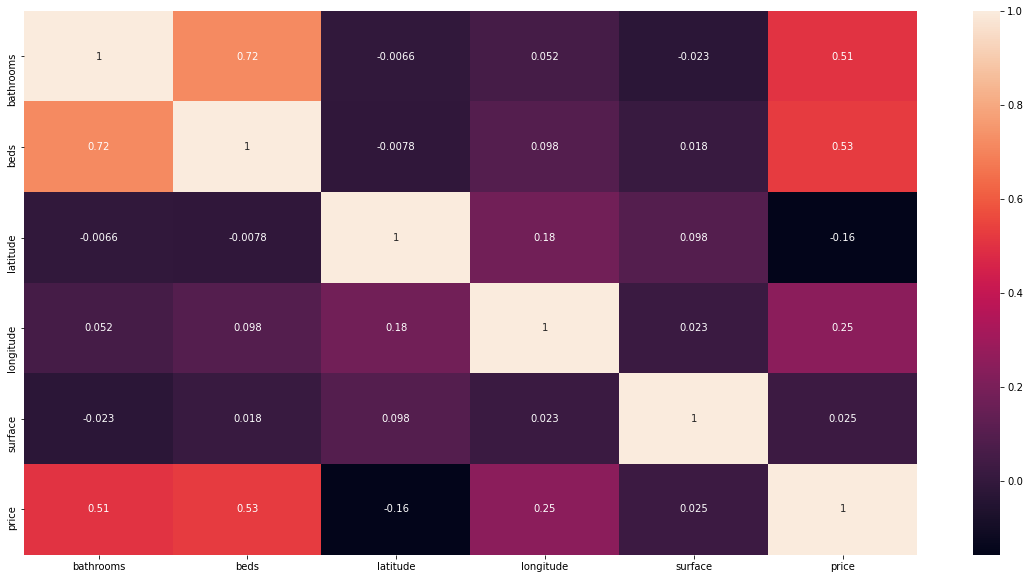

In [55]:
sns.heatmap(df_train.corr(), annot = True)

The most influential explanatory variables are **beds**, **bathrooms** followed at a distance by **longitude** and **latitude**.

### Load Test Data Set

In [56]:
# load test dataset
df_test = pd.read_csv(testing_file)

In [57]:
# show first data frame rows of the test df
df_test.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
0,12373510,Skerries,2.0,4.0,G,Dublin,"It's all in the name ""Island View"";. Truly won...",prod,"Parking,Alarm,Oil Fired Central Heating",Breath-taking panoramic views radiate from thi...,53.566881,-6.101148,NaN,sale,bungalow,142.0
1,12422623,Lucan,2.0,3.0,C1,Dublin,REA McDonald - Lucan' s longest established es...,prod,NaN,Gas fired central heating.\nDouble glazed wind...,53.362992,-6.452909,NaN,sale,terraced,114.0
2,12377408,Swords,3.0,4.0,B3,Dublin,REA Grimes are proud to present to the market ...,prod,NaN,Pristine condition throughout\nHighly sought-a...,53.454198,-6.262964,NaN,sale,semi-detached,172.0
3,12420093,Lucan,4.0,3.0,A3,Dublin,"REA McDonald, Lucan' s longest established est...",prod,NaN,A-rated home within a short walk of Lucan Vill...,53.354402,-6.458647,NaN,sale,semi-detached,132.4
4,12417338,Clondalkin,1.0,3.0,E2,Dublin,"Hibernian Auctioneers are delighted to bring, ...",prod,"Parking,Gas Fired Central Heating,Wired for Ca...",Mature Location \nGas Heating \nClose to Ameni...,53.336530,-6.393587,NaN,sale,semi-detached,88.0


We repeat removal of features we have removed from the train dataset.

In [58]:
df_test.drop(['description_block', 'features', 'facility', 'no_of_units', 'ad_id'], axis=1, inplace=True)

In [59]:
df_test.isna().sum()

area                   0
bathrooms              0
beds                   0
ber_classification    56
county                 0
environment            0
latitude               0
longitude              0
property_category      0
property_type          0
surface                0
dtype: int64

In [60]:
# Generate descriptive statistics
df_test.describe()

,bathrooms,beds,latitude,longitude,surface
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.994000,2.930000,53.356034,-6.247842,156.007671
std,1.106532,1.191612,0.081905,0.088552,344.497362
min,0.000000,0.000000,53.221348,-6.496987,33.500000
25%,1.000000,2.000000,53.297373,-6.296404,72.375000
50%,2.000000,3.000000,53.339547,-6.243572,98.000000
75%,3.000000,4.000000,53.381650,-6.185055,138.935000
max,8.000000,7.000000,53.619775,-6.064874,5746.536120


### Expected Cost dataset

In [61]:
# load train dataset
df_cost = pd.read_csv(cost_file)

# show first data frame rows
df_cost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [62]:
# Generate descriptive statistics
df_cost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


In [63]:
df_cost.isna().sum()

Id          0
Expected    0
dtype: int64

In [64]:
# show data set shape
df_train.shape

(2929, 12)

In [65]:
# show data set shape
df_test.shape

(500, 11)

In [66]:
# show data set shape
df_cost.shape

(500, 2)

In [67]:
# X_train is from train data set except column price
X_train = df_train.loc[:, df_train.columns != 'price']

# X_test is from test data set
X_test = df_test

# y_train is form train data set with column price
y_train = df_train[['price']]

# y_test is from true price with column Expected
y_test =  df_cost[['Expected']]

In [68]:
X_train

,area,bathrooms,beds,ber_classification,county,environment,latitude,longitude,property_category,property_type,surface
15,Clonee,3.0,5.0,A3,Dublin,prod,53.400454,-6.445730,new_development_parent,detached,321.0
26,Clondalkin,4.0,4.0,A3,Dublin,prod,53.316410,-6.385214,new_development_parent,semi-detached,144.0
27,Clonee,3.0,5.0,A3,Dublin,prod,53.401414,-6.446634,new_development_parent,detached,321.0
35,Howth,5.0,5.0,A2,Dublin,prod,53.375377,-6.056749,new_development_parent,detached,312.0
38,Castleknock,2.0,2.0,A3,Dublin,prod,53.372130,-6.338466,new_development_parent,apartment,83.0
...,...,...,...,...,...,...,...,...,...,...,...
2977,Ballsbridge,2.0,2.0,C3,Dublin,prod,53.338738,-6.237199,sale,apartment,56.0
2978,Rialto,1.0,3.0,B2,Dublin,prod,53.335793,-6.294268,sale,terraced,101.0
2979,Smithfield,1.0,2.0,C3,Dublin,prod,53.346098,-6.276856,sale,apartment,55.6
2980,Foxrock,2.0,3.0,C3,Dublin,prod,53.273518,-6.178500,sale,end-of-terrace,97.0


In [69]:
X_test

,area,bathrooms,beds,ber_classification,county,environment,latitude,longitude,property_category,property_type,surface
0,Skerries,2.0,4.0,G,Dublin,prod,53.566881,-6.101148,sale,bungalow,142.0
1,Lucan,2.0,3.0,C1,Dublin,prod,53.362992,-6.452909,sale,terraced,114.0
2,Swords,3.0,4.0,B3,Dublin,prod,53.454198,-6.262964,sale,semi-detached,172.0
3,Lucan,4.0,3.0,A3,Dublin,prod,53.354402,-6.458647,sale,semi-detached,132.4
4,Clondalkin,1.0,3.0,E2,Dublin,prod,53.336530,-6.393587,sale,semi-detached,88.0
...,...,...,...,...,...,...,...,...,...,...,...
495,Ringsend,1.0,2.0,NaN,Dublin,prod,53.342207,-6.226101,sale,apartment,65.0
496,Cabinteely,3.0,5.0,E1,Dublin,prod,53.261475,-6.147720,sale,detached,191.3
497,Artane,1.0,3.0,G,Dublin,prod,53.391619,-6.205157,sale,detached,105.0
498,Clontarf,2.0,4.0,E2,Dublin,prod,53.360578,-6.183701,sale,end-of-terrace,130.0


In [70]:
y_train

,price
15,935000.0
26,485000.0
27,935000.0
35,1475000.0
38,410000.0
...,...
2977,415000.0
2978,485000.0
2979,299000.0
2980,495000.0


In [71]:
y_test

,Expected
0,875000.0
1,355000.0
2,440000.0
3,425000.0
4,265000.0
...,...
495,345000.0
496,775000.0
497,360000.0
498,925000.0


# PIECEWISE REGRESSION

## Full Model

In [72]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['beds', 'latitude', 'longitude', 'surface','price']
# dropna: remove missing values
df_subset_train = df_train[featrain].dropna(axis=0)

featest = ['beds', 'latitude', 'longitude', 'surface']
df_subset_test  =  df_test[featest].dropna(axis=0)

# cost
df_cost = df_cost[df_cost.index.isin(df_subset_test.index)]

In [73]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


<AxesSubplot:>

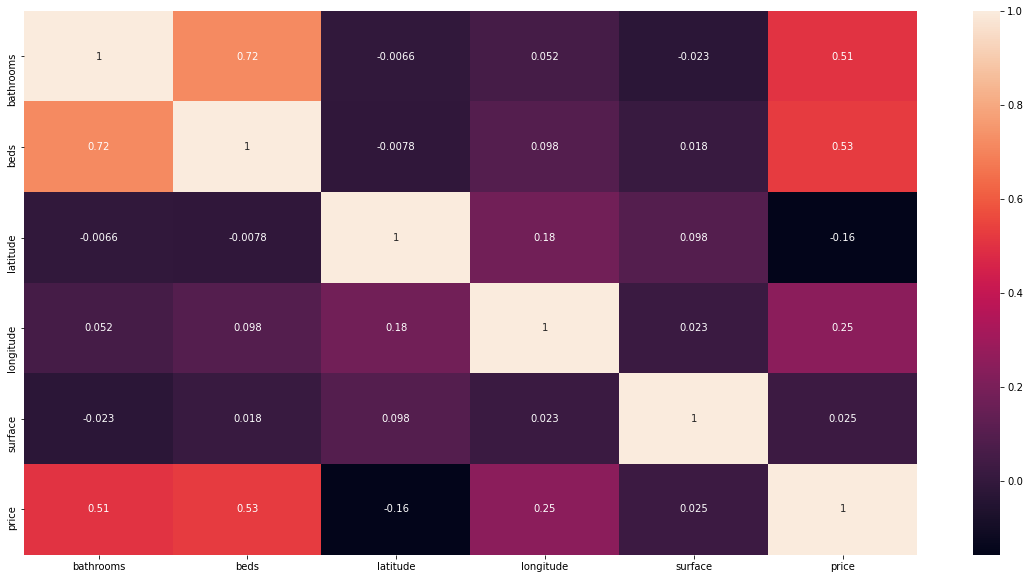

In [74]:
sns.heatmap(df_train.corr(), annot = True)

### Make some observations on the correlations 

In [75]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost['Expected'].values

In [76]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [77]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,538.4


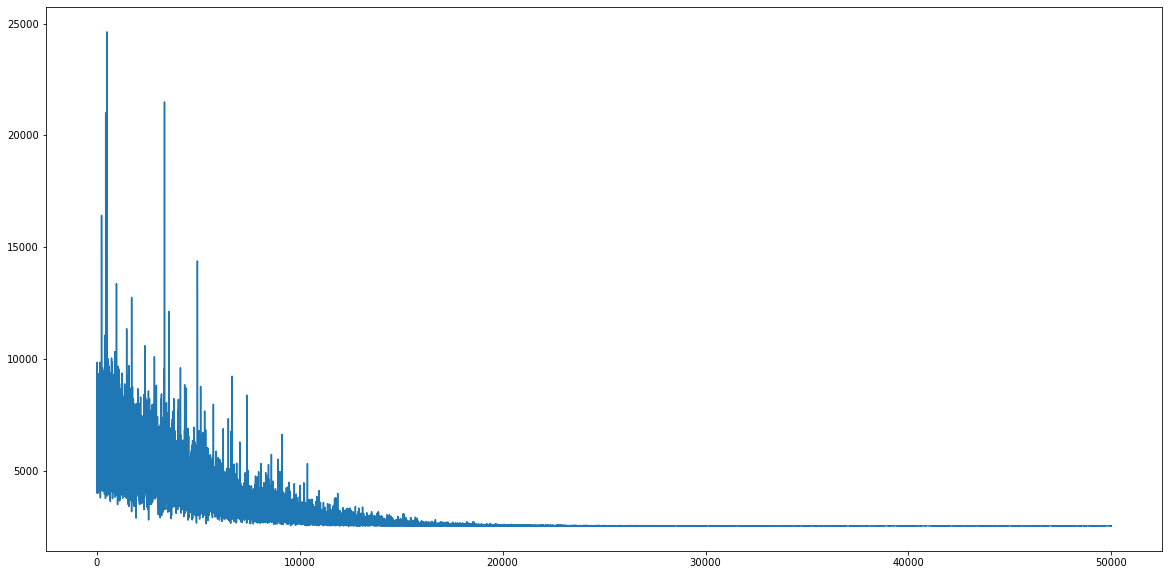

In [78]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [79]:
# samples from the posterior
posterior = approximation.sample(5000)

In [80]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  212491.62242743495
MAPE =  0.28230225411959653


###  MAE and MAPE, what are they and why we use them. 



https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3

https://www.statisticshowto.com/mean-absolute-percentage-error-mape/



## Clustering

To determine how many clusters to use we analyze different k values for k-means clustering and look for a knee in the resultant graph.  
We'll also use the silhouette effect for added information in determing the correct number of clusters to use.  

In [81]:
inertia = []
for k in range(1,15):
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=20, max_iter=500, random_state=10).fit(Xn_train)
    inertia.append(clustered_data_sklearn.inertia_)

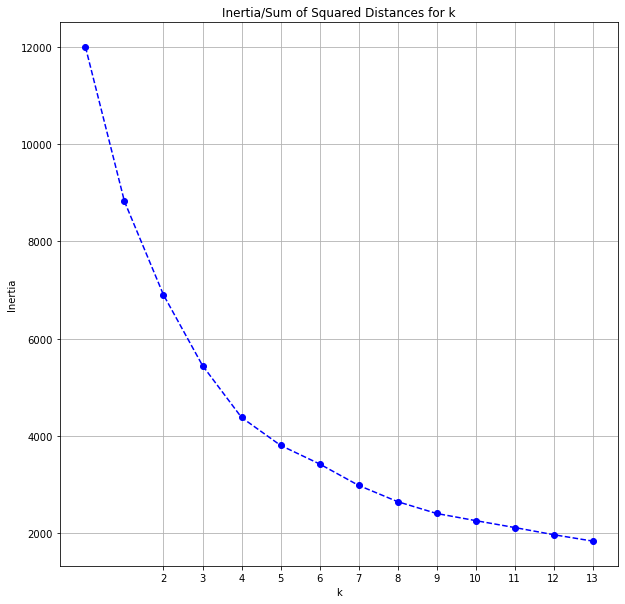

In [82]:
plt.figure(figsize=(10,10))
plt.title('Inertia/Sum of Squared Distances for k')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(range(2, 30))
plt.grid()
plt.plot(inertia, linestyle='--', marker='o', color='b')

In [83]:
# As per website: https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters 
silhouette_coefficients = []
   
# Start at 2 clusters for silhouette coefficient
for k in range(2, 15):
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=20, max_iter=500, random_state=10).fit(Xn_train)
    score = silhouette_score(Xn_train, clustered_data_sklearn.labels_)
    silhouette_coefficients.append(score)

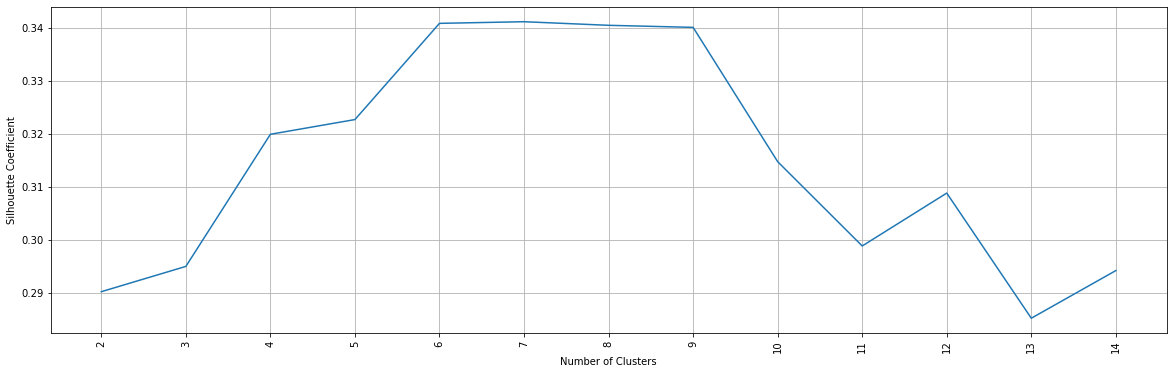

In [84]:
plt.figure(figsize=(20,6))
plt.plot(range(2,15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xticks(rotation=90)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.grid()
plt.show() 

In reviewing k-means for different number of clusters we see a knee point at about 5. This implies we should use 5 clusters.  

With the silhouette score we look for the maximum value and at which number of clusters it occurs. Here we see a maximum value occuring at 7 clusters. Ultimately it is on us to interpret the graphs. We will try 5 clusters.

### Full Model

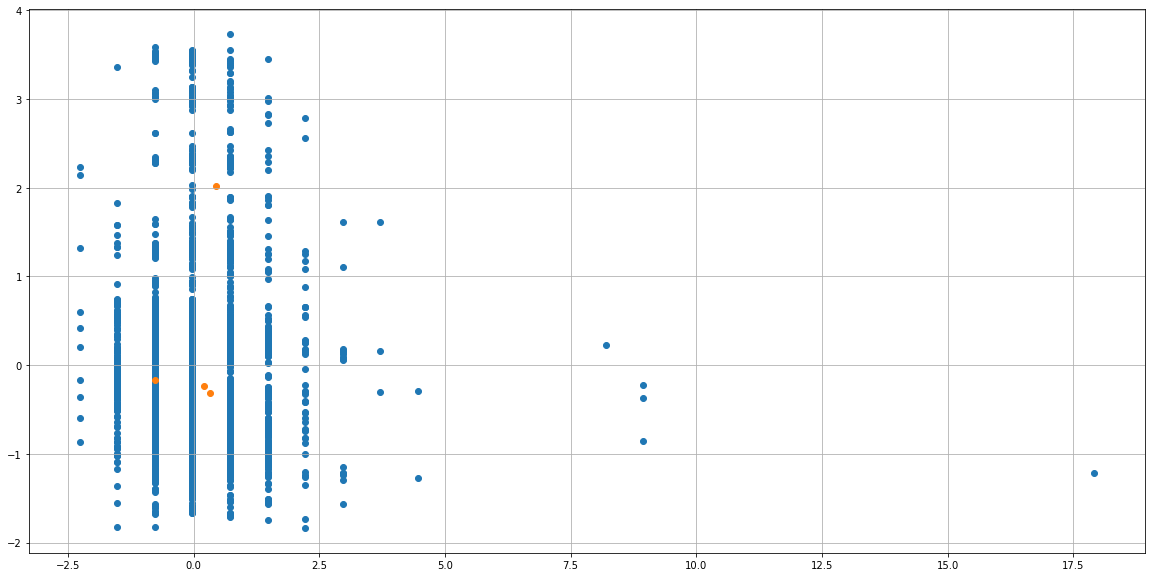

In [85]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])

# Gaussian Mixture
gmm.fit(X_ind)
plt.grid()
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])

# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [43]:
np.max(ys_train)

9995000.0

## There are some outliers here, should we remove?

### Clusters

In [44]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 1191, 1: 25, 2: 318, 3: 868}

In [45]:
len(Xn_test)

500

In [46]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 235, 1: 5, 2: 76, 3: 184}

In [47]:
len(clusters_train)

2402

In [48]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [49]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [50]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [51]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [52]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

In [53]:
with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,283.3


In [54]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 57.145


In [55]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 347.99


In [56]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 741.81


In [57]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

##Simulations

### Only Cluster 0

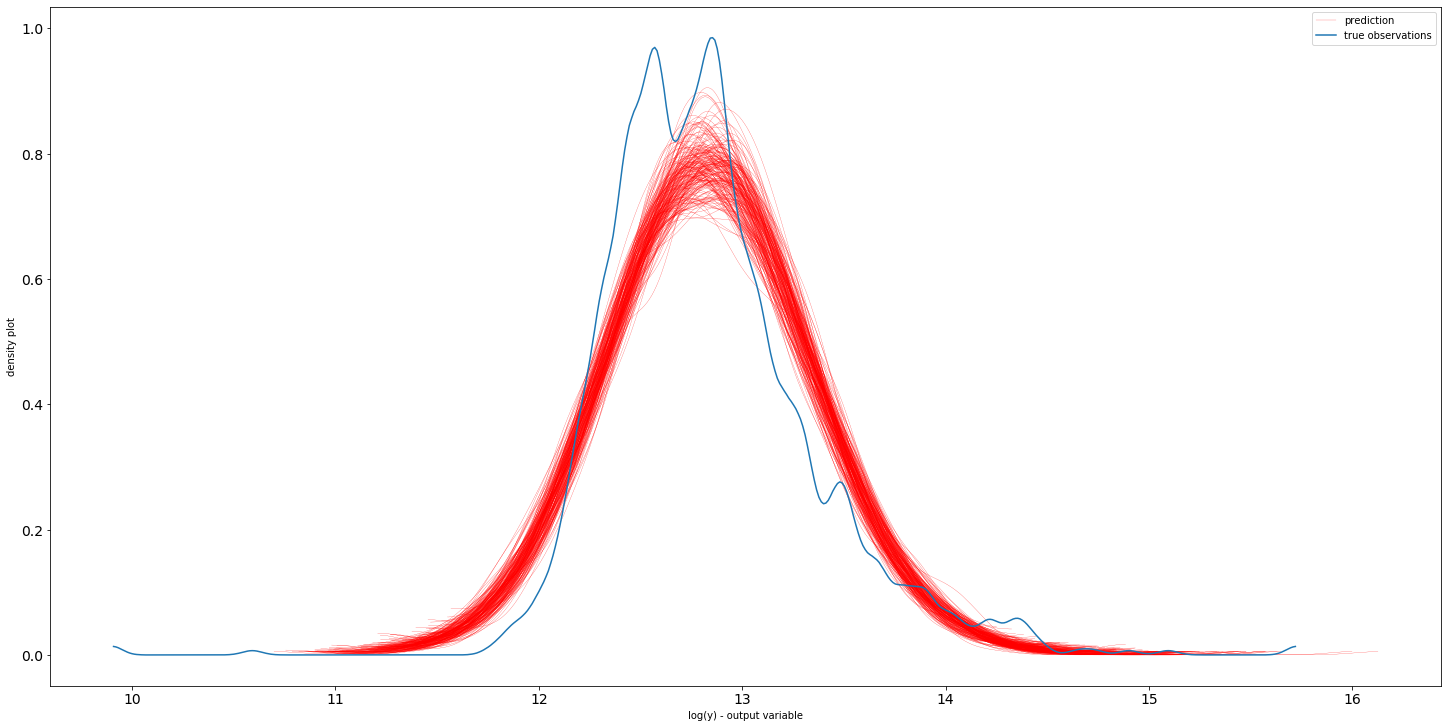

In [58]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 1

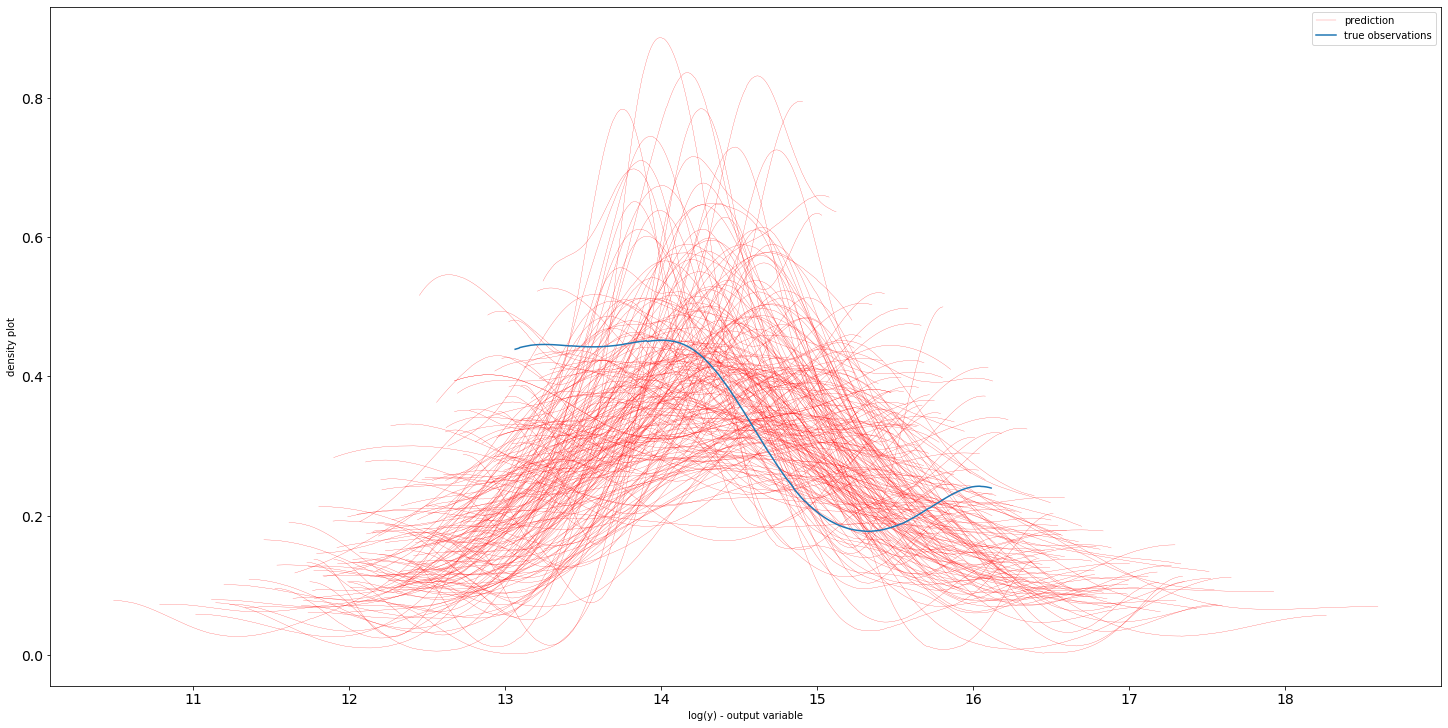

In [59]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 2

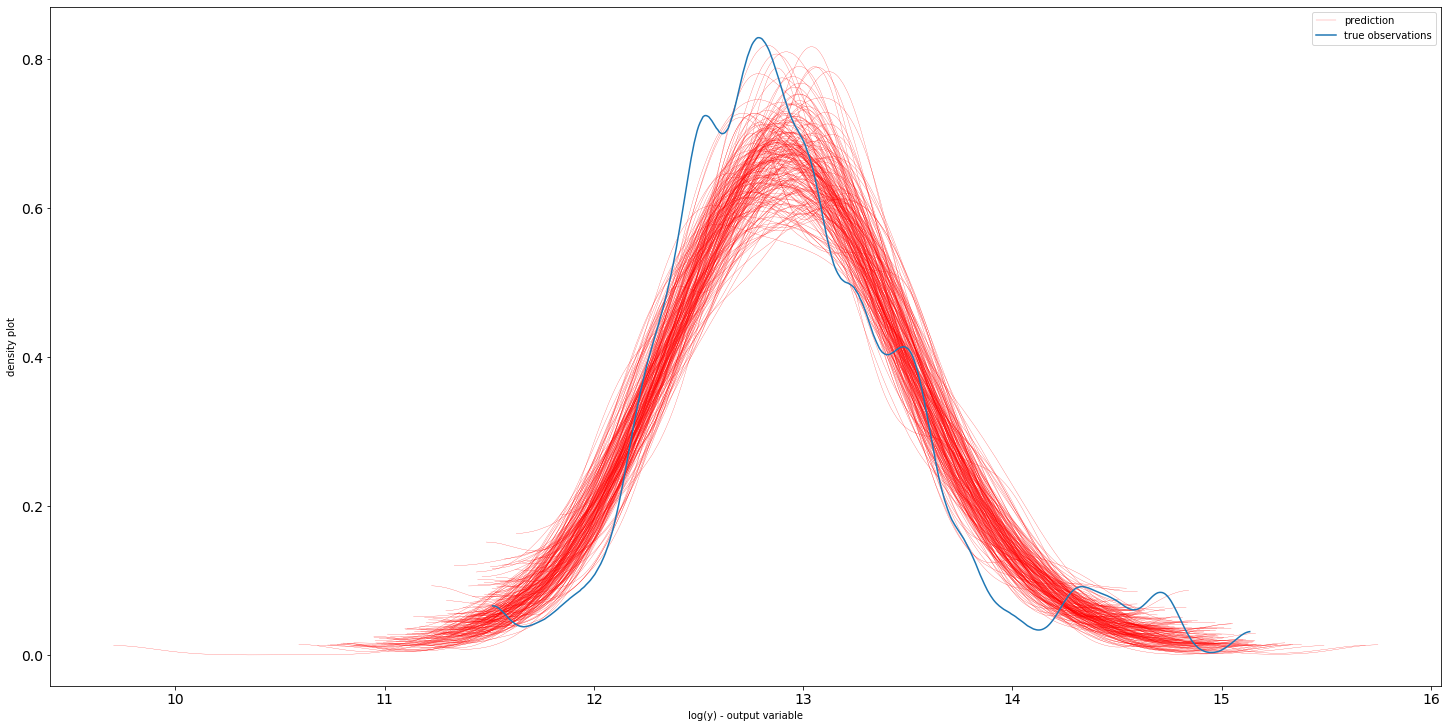

In [60]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

### Only Cluster 3

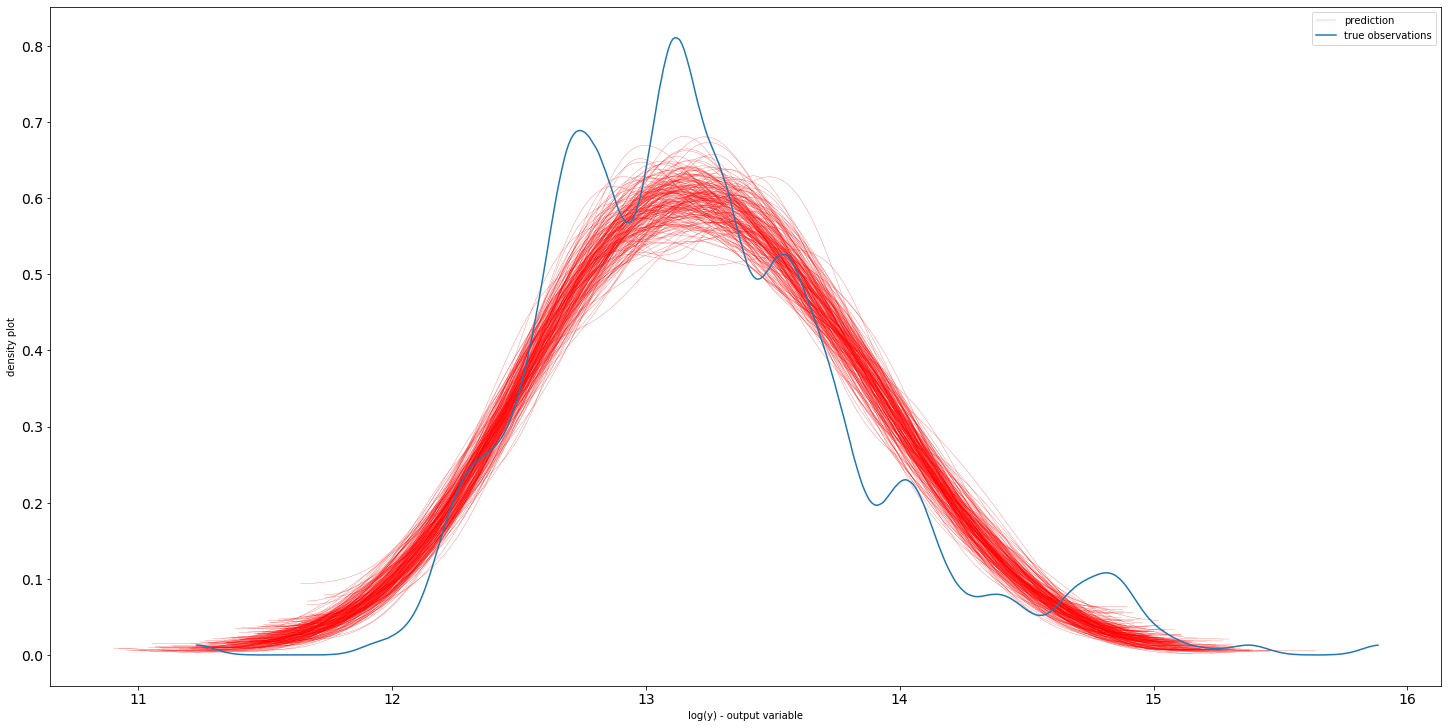

In [61]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

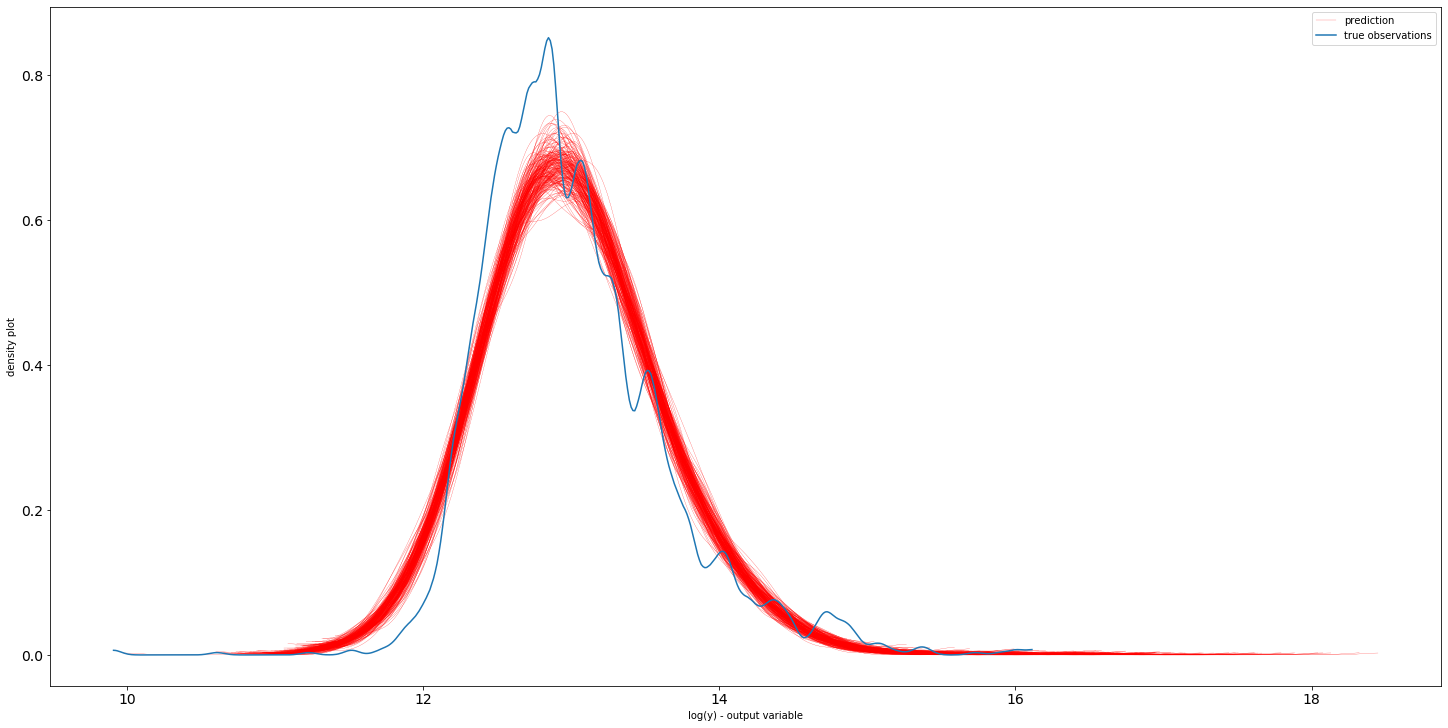

In [62]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [63]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 235 , MAE Cluster0= 125936.92716251824
Size Cluster1 5 , MAE Cluster1= 440760.470217995
Size Cluster2 76 , MAE Cluster2= 152347.18460545733
Size Cluster3 184 , MAE Cluster3= 261798.43027157427
MAE= 183096.55486853237


### PPC on the Test set



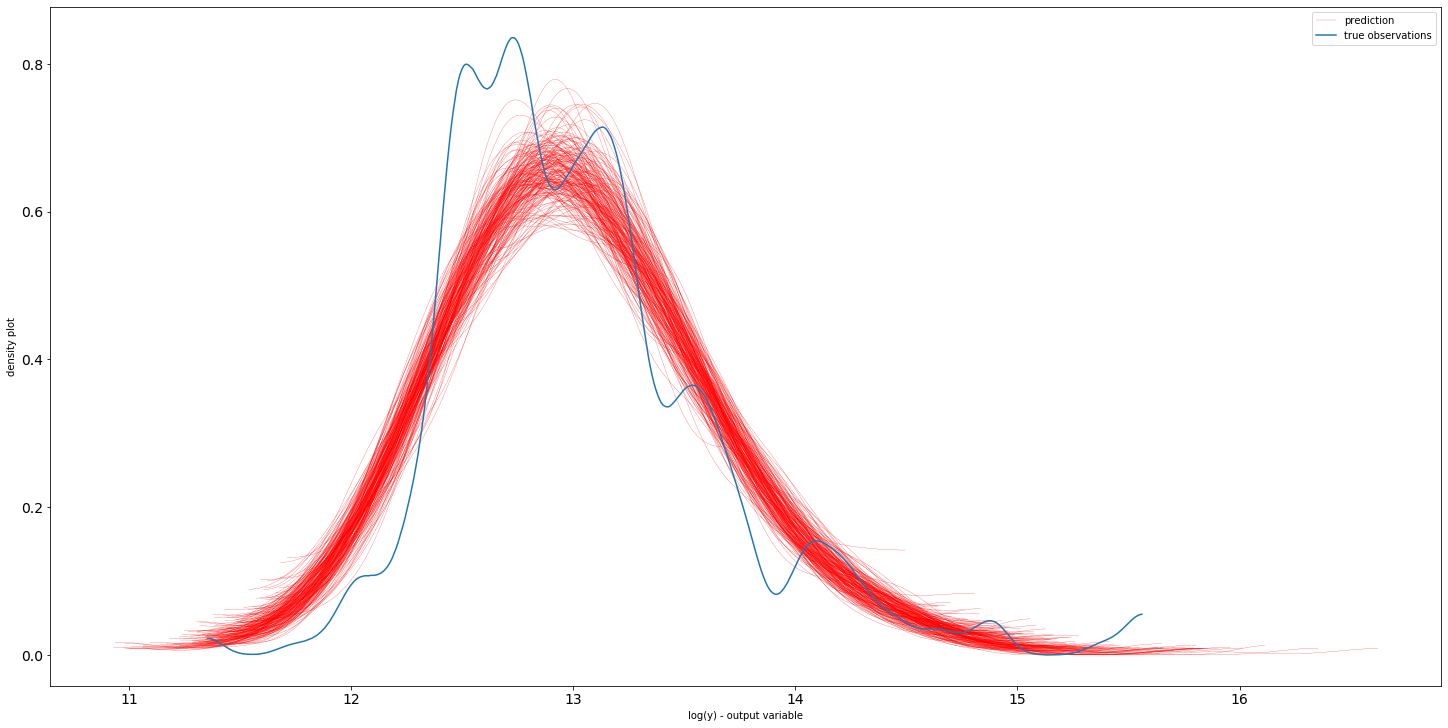

In [64]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# SUMMARY